# CSCA 5632 Final Project

Project goal: to learn unsupervised learning algorithms, and compare them to supervised learning algorithms. 

## Collect data

This project uses a dataset that is often used in academic publications to benchmark the performance of modeling algorithms: Adult Census Income. The source is: https://www.kaggle.com/datasets/uciml/adult-census-income

Each entry of the dataset contains the following information about an individual: 
- age: the age of an individual 
    - Integer greater than 0 
- workclass: a general term to represent the employment status of an individual 
    - Private, Self emp not inc, Self emp inc, Federal gov, Local gov, State gov, Without pay, Never worked. 
- fnlwgt: final weight. In other words, this is the number of people the census believes the entry represents.. 
    - Integer greater than 0 
- education: the highest level of education achieved by an individual. 
    - Bachelors, Some college, 11th, HS grad, Prof school, Assoc acdm, Assoc voc, 9th, 7th 8th, 12th, Masters, 1st 4th, 10th, Doctorate, 5th 6th, Preschool. 
- education num: the highest level of education achieved in numerical form. 
    - Integer greater than 0 
- marital status: marital status of an individual. Married civ spouse corresponds to a civilian spouse while Married AF spouse is a spouse in the Armed Forces. 
    - Married civ spouse, Divorced, Never married, Separated, Widowed, Married spouse absent, Married AF spouse. 
- occupation: the general type of occupation of an individual 
    - Tech support, Craft repair, Other service, Sales, Exec managerial, Prof specialty, Handlers cleaners, Machine op inspct, Adm clerical, Farming fishing, Transport moving, Priv house serv, Protective serv, Armed Forces. 
- relationship: represents what this individual is relative to others. For example an individual could be a Husband. Each entry only has one relationship attribute and is somewhat redundant with marital status. We might not make use of this attribute at all 
    - Wife, Own child, Husband, Not in family, Other relative, Unmarried. 
- race: Descriptions of an individual’s race 
    - White, Asian Pac Islander, Amer Indian Eskimo, Other, Black. 
- sex: the biological sex of the individual 
    - Male, Female 
- capital gain: capital gains for an individual 
    - Integer greater than or equal to 0 
- capital loss: capital loss for an individual 
    - Integer greater than or equal to 0 
- hours per week: the hours an individual has reported to work per week 
    - continuous. 
- native country: country of origin for an individual 
    - United States, Cambodia, England, Puerto Rico, Canada, Germany, Outlying US(Guam USVI etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El Salvador, Trinadad&Tobago, Peru, Hong, Holand Netherlands. 
- income: whether or not an individual makes more than $50,000 annually. 
    - <=50k, >50k  

The prediction task is to determine whether an individual makes over $50K a year.

## Identify an unsupervised learning problem

The true target - a binary variable recording whether a given individual makes over $50K a year - is included in the dataset, making the problem a typical supervised learning prediction task. However, we still can approach it with unsupervised learning methods. We will use K-Means clustering to separate the subjects into two groups, and then evaluate how well these two groups correspond to the true target.  

We will also approach this problem with a supervised learning algorithm, and then compare their performances.

## Prepare the project

In [8]:
# utilities
import itertools
import pickle
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# general purpose
import numpy as np
import pandas as pd 

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# data processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder

# model training and evaluating
from sklearn.metrics import recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV

# modeling algorithms
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [9]:
working_folder = '/home/lee/Documents/Week5/csca5632 week5/'
data_folder = working_folder + 'data/'
adult = pd.read_csv(data_folder + 'adult.csv')

## Perform EDA

### Describe the factors that make up the dataset

First, look at the dataset structure.  

In [10]:
adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Data size:

In [11]:
print(f'dataset shape: {adult.shape}')

dataset shape: (32561, 15)


In [12]:
data_dtypes = adult.dtypes.to_dict()

categorical_cols = []
numeric_cols = []

for col in data_dtypes.keys():
    if data_dtypes[col] == 'object':
        categorical_cols.append(col)
    elif data_dtypes[col] == 'int64':
        numeric_cols.append(col)
        
print(f'Categorical fields of the raw dataset: {categorical_cols}')
print(f'Continuous fields of the raw dataset: {numeric_cols}')

Categorical fields of the raw dataset: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
Continuous fields of the raw dataset: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


### Describe the distribution of each factor

Factor: age
count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
90%         58.000000
95%         63.000000
99%         74.000000
max         90.000000
Name: age, dtype: float64


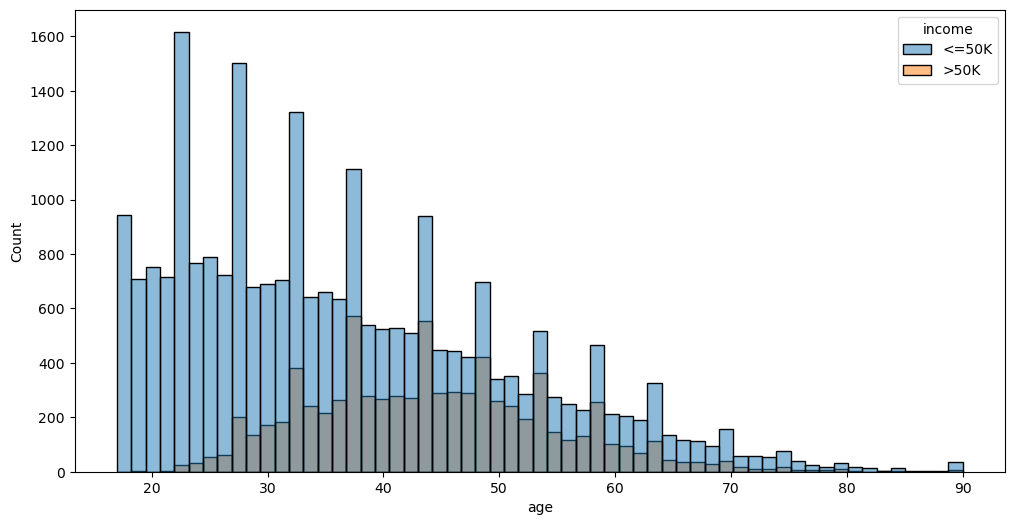



Factor: fnlwgt
count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
90%      3.290540e+05
95%      3.796820e+05
99%      5.100720e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64


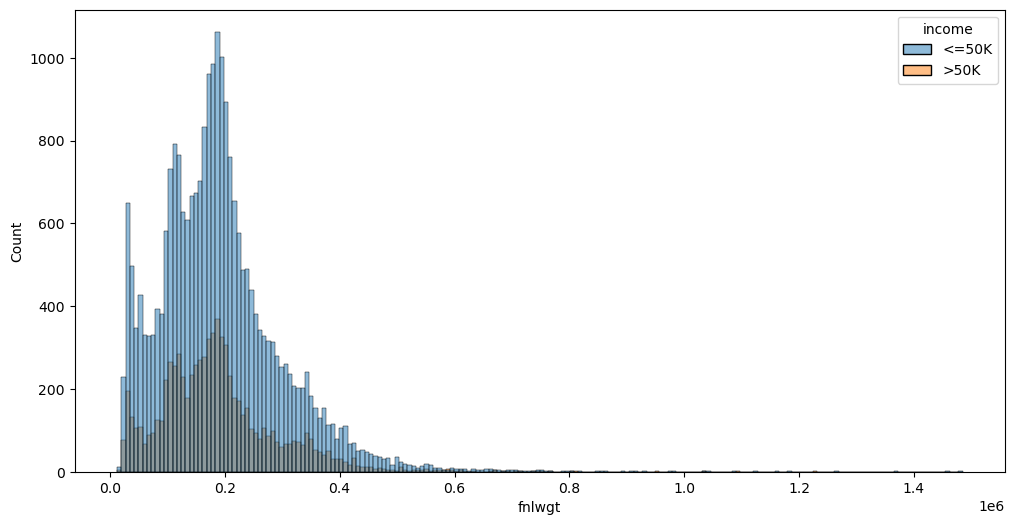



Factor: education.num
count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
90%         13.000000
95%         14.000000
99%         16.000000
max         16.000000
Name: education.num, dtype: float64


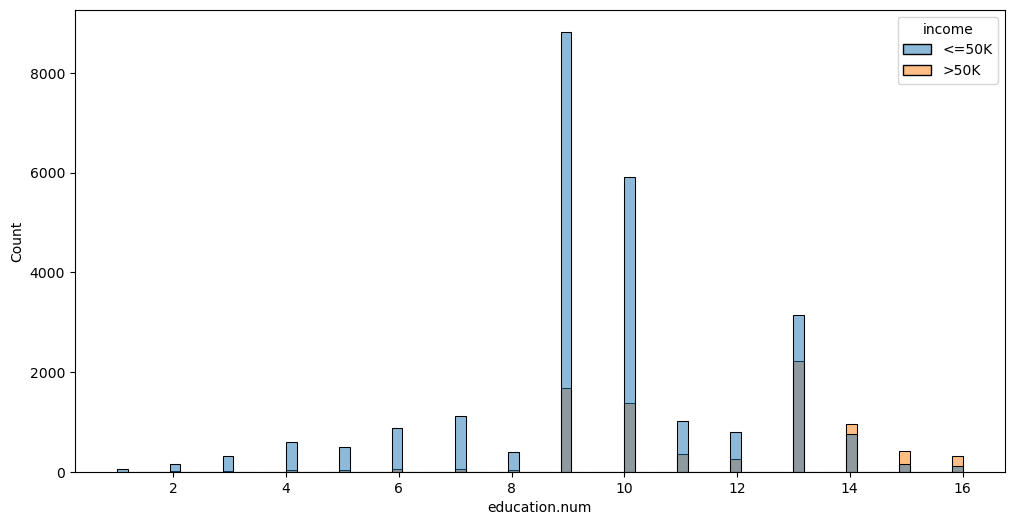



Factor: capital.gain
count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%       5013.000000
99%      15024.000000
max      99999.000000
Name: capital.gain, dtype: float64


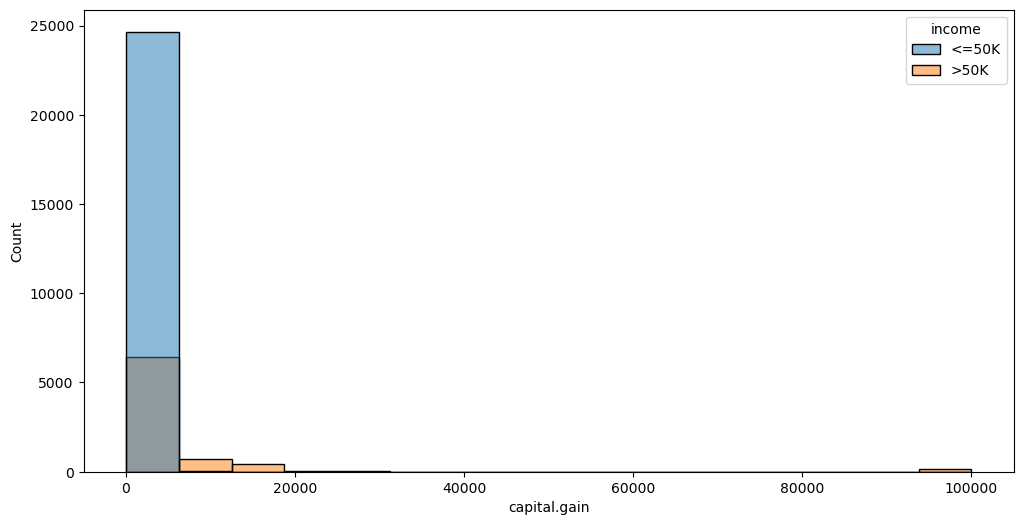



Factor: capital.loss
count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%       1980.000000
max       4356.000000
Name: capital.loss, dtype: float64


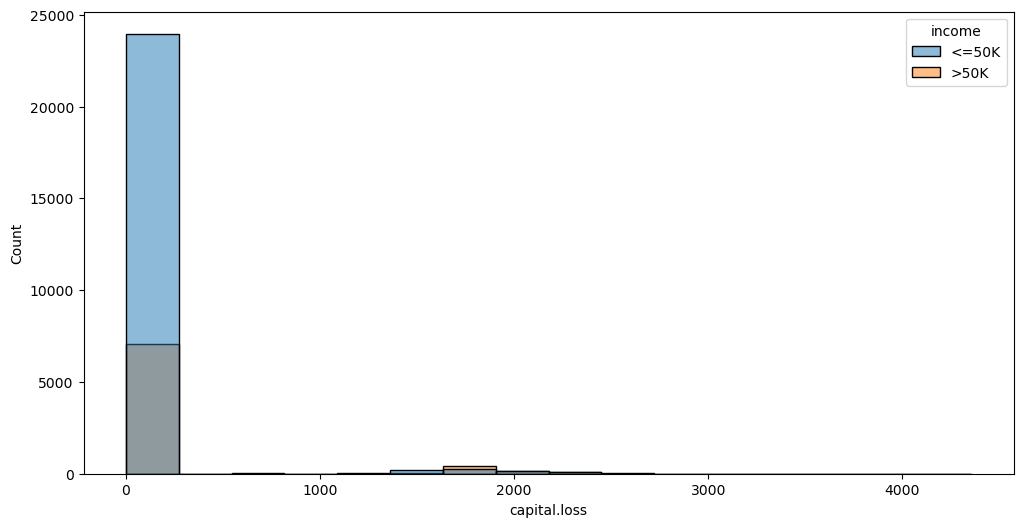



Factor: hours.per.week
count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
90%         55.000000
95%         60.000000
99%         80.000000
max         99.000000
Name: hours.per.week, dtype: float64


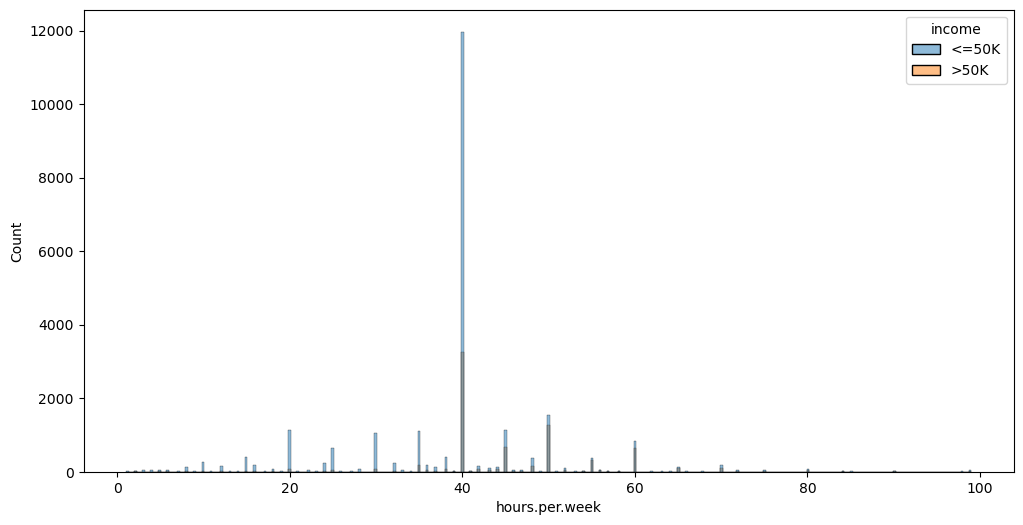

In [13]:
for col in numeric_cols:
    print(f'Factor: {col}')
    print(adult[col].describe(percentiles=(.25, .5, .75, .9, .95, .99)))
    plt.figure(figsize=(12, 6))
    sns.histplot(adult, x=col, hue="income")
    plt.show()
    print('\n')

Factor: workclass
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
number of unique values of workclass: 9


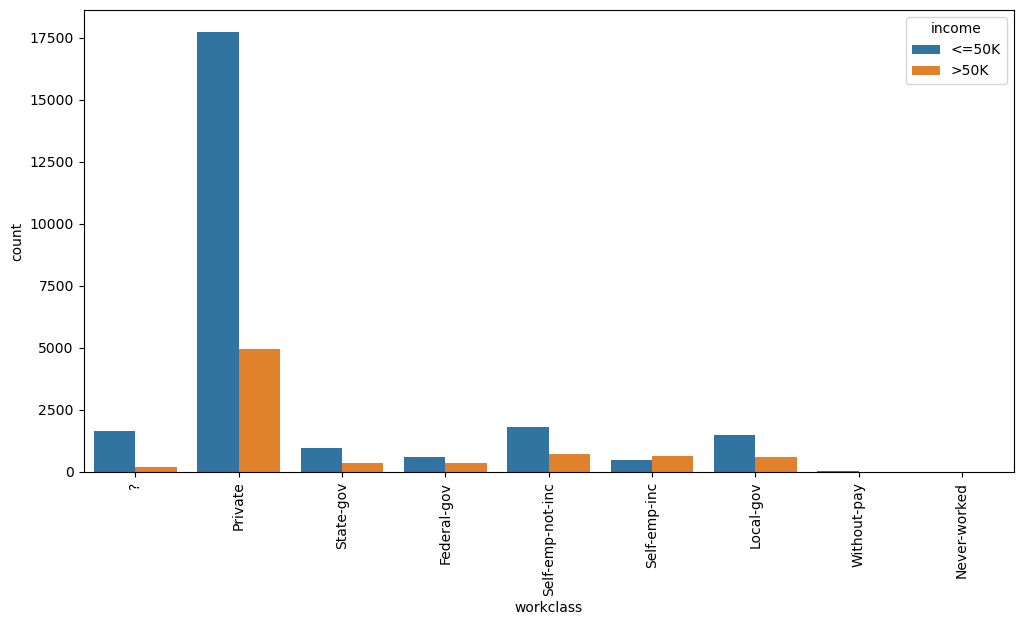



Factor: education
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64
number of unique values of education: 16


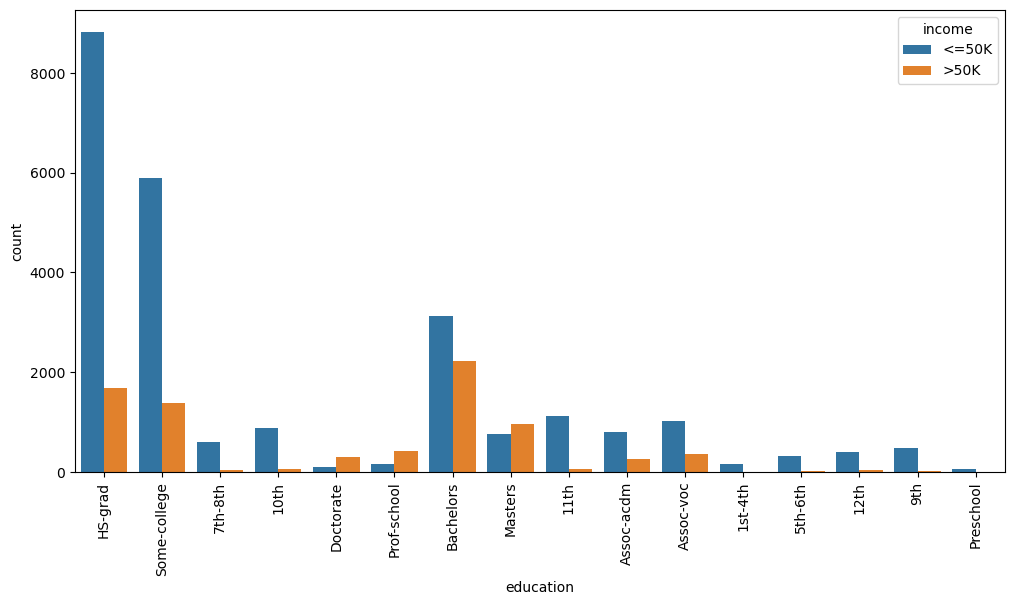



Factor: marital.status
marital.status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64
number of unique values of marital.status: 7


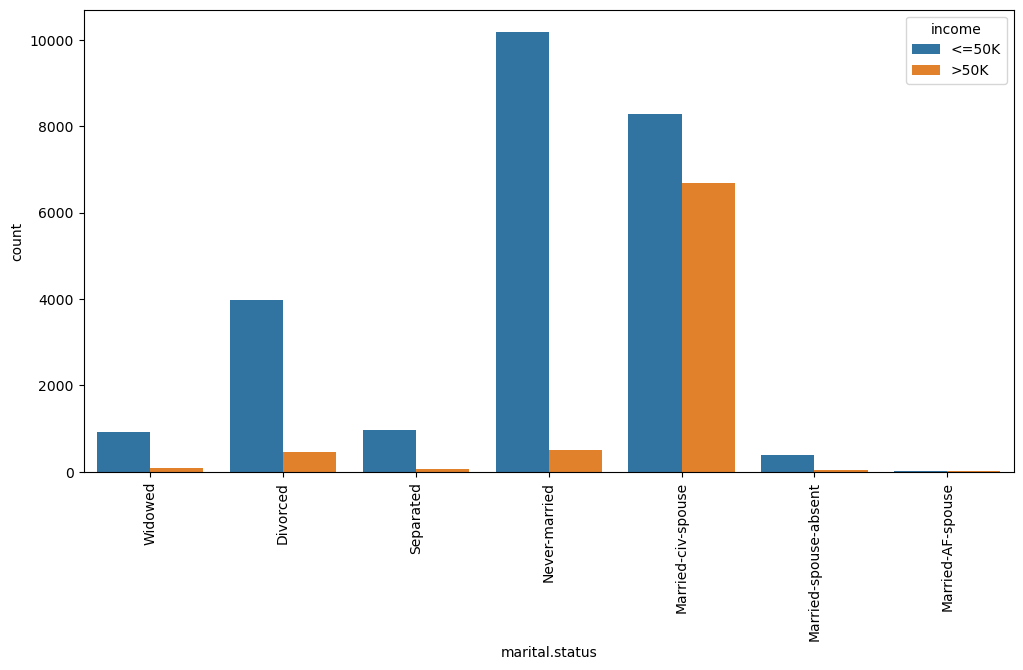



Factor: occupation
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64
number of unique values of occupation: 15


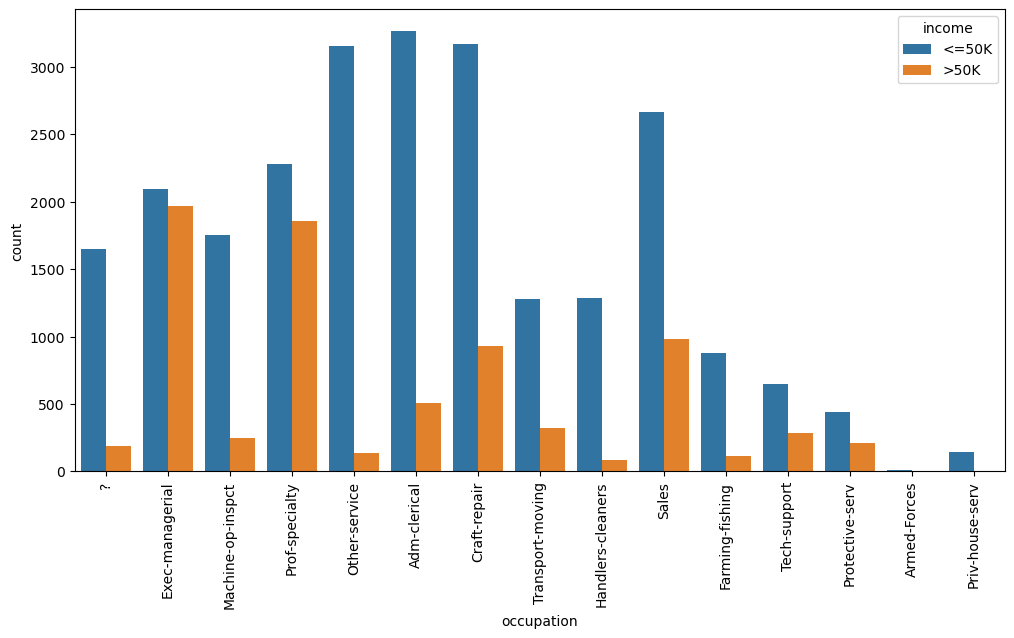



Factor: relationship
relationship
Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: count, dtype: int64
number of unique values of relationship: 6


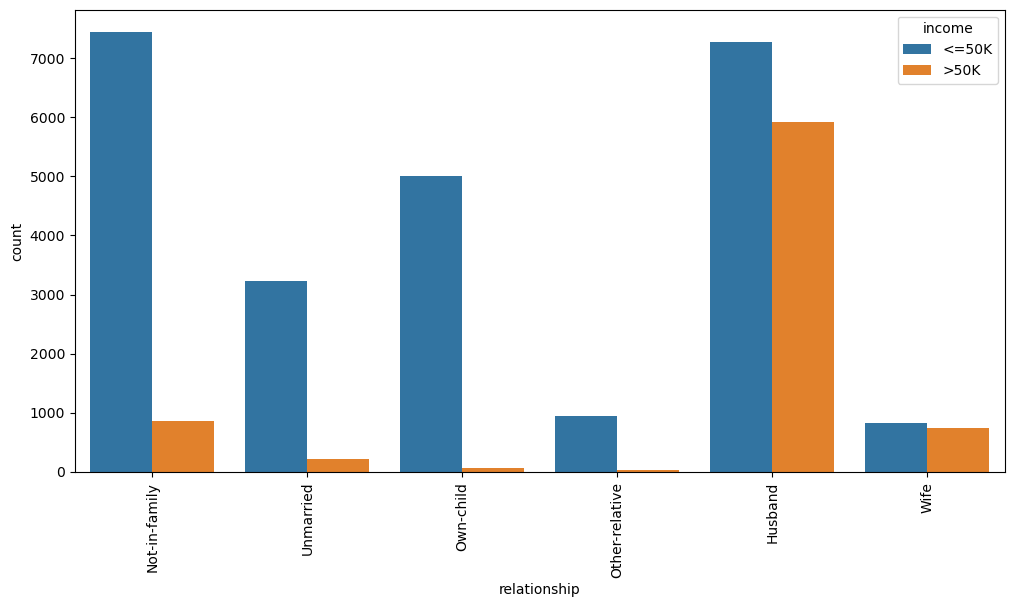



Factor: race
race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64
number of unique values of race: 5


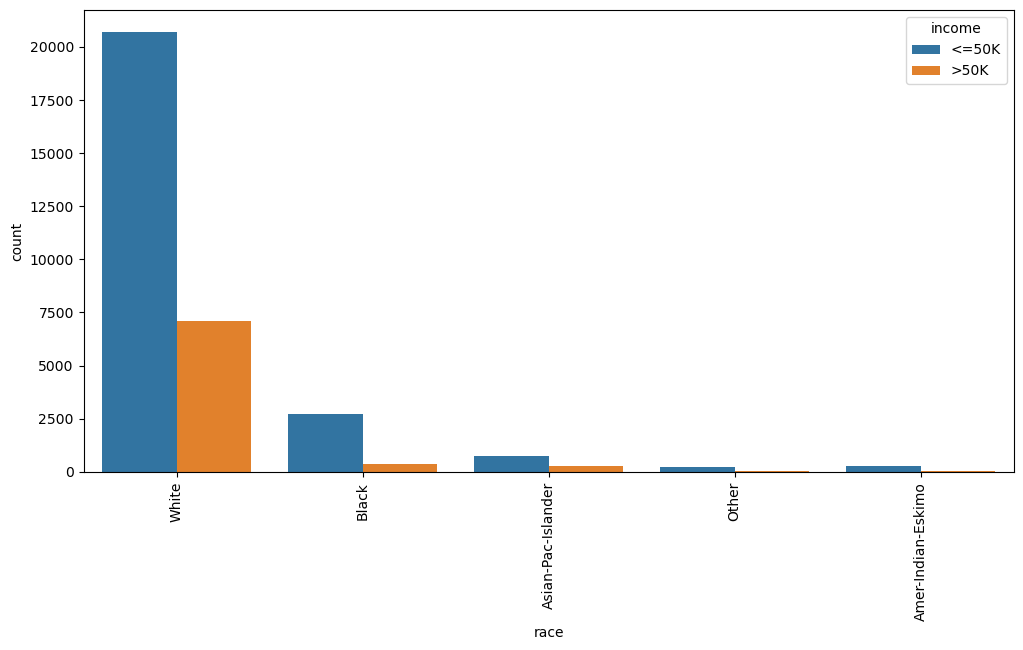



Factor: sex
sex
Male      21790
Female    10771
Name: count, dtype: int64
number of unique values of sex: 2


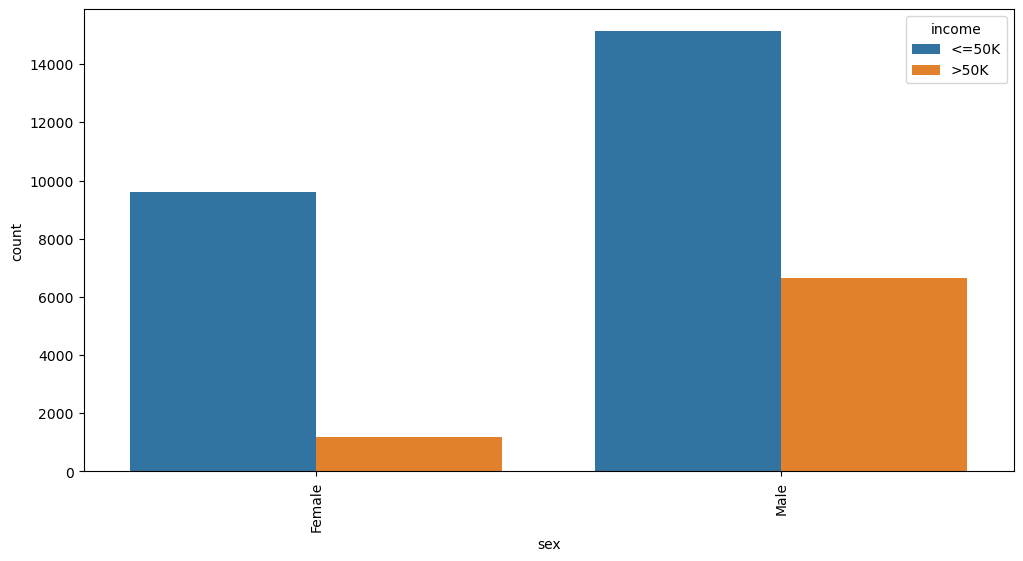



Factor: native.country
native.country
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                    

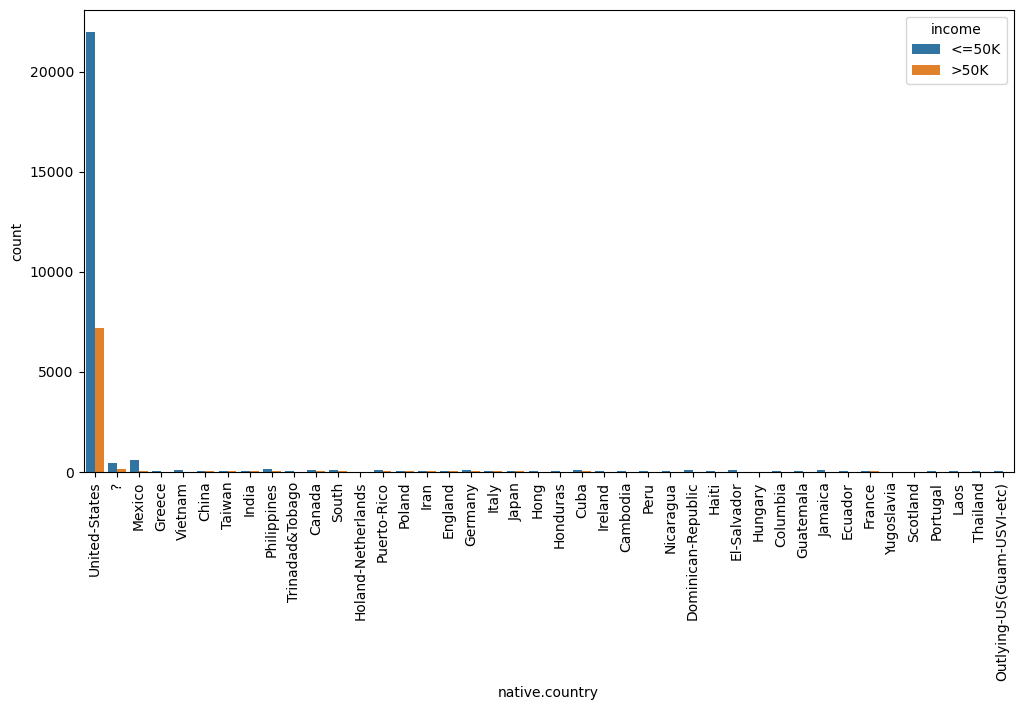



Factor: income
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
number of unique values of income: 2


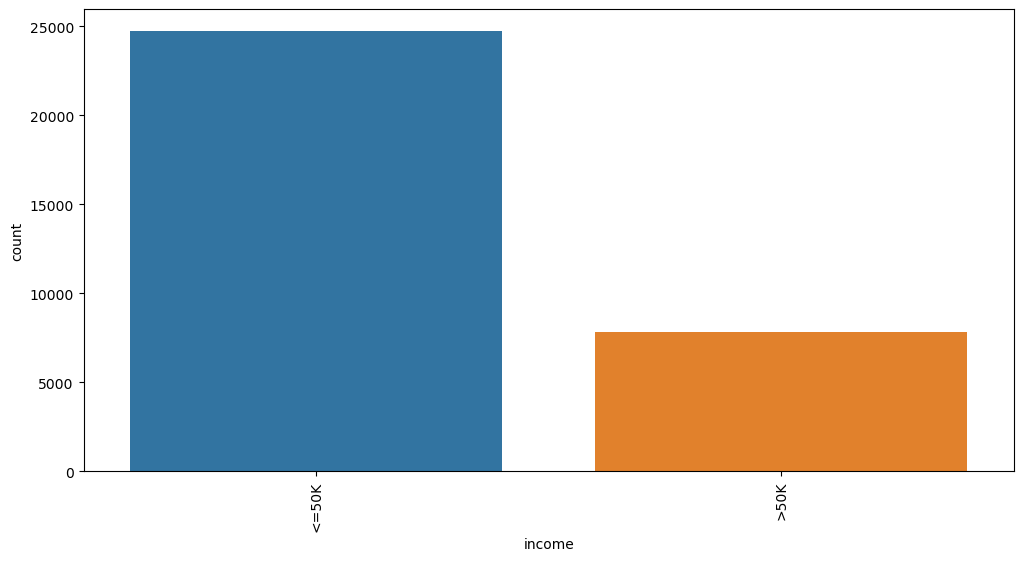

In [14]:
for col in categorical_cols:
    print(f'Factor: {col}')
    print(adult[col].value_counts())
    print(f'number of unique values of {col}: {adult[col].nunique()}')
    plt.figure(figsize=(12, 6))
    plt.xticks(rotation=90)
    sns.countplot(adult, x=col, hue="income")
    plt.show()
    print('\n')

Are the classes of the label balanced?

In [15]:
adult['income'].value_counts(normalize=True)

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

The labels are reasonably balanced. We will use accuracy to measure model performance.

### Describe correlations between different factors

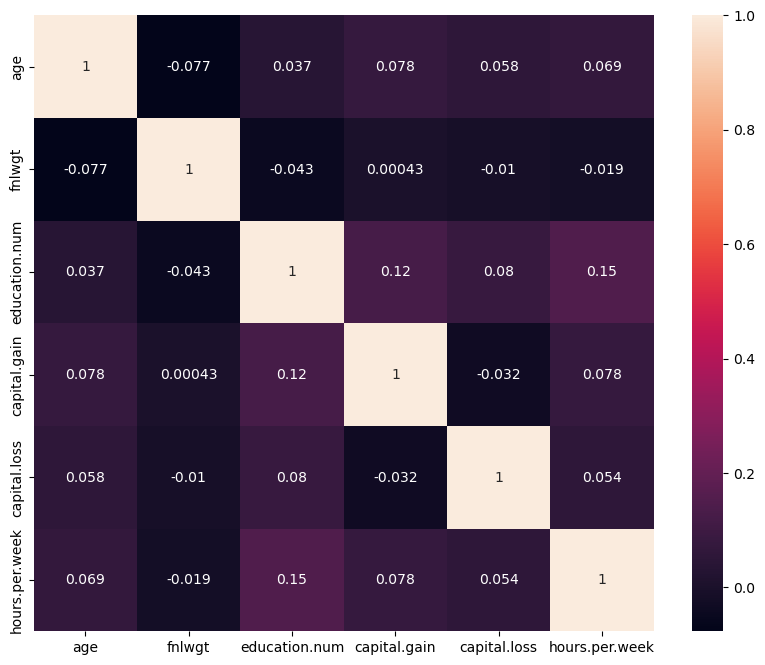

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(adult[numeric_cols].corr(), annot=True)
plt.show()

The correlations among the continuous variables appear to be weak.

Intuitively, `education` and `education.num` would be highly correlated. Exactly how strong is this relationship?

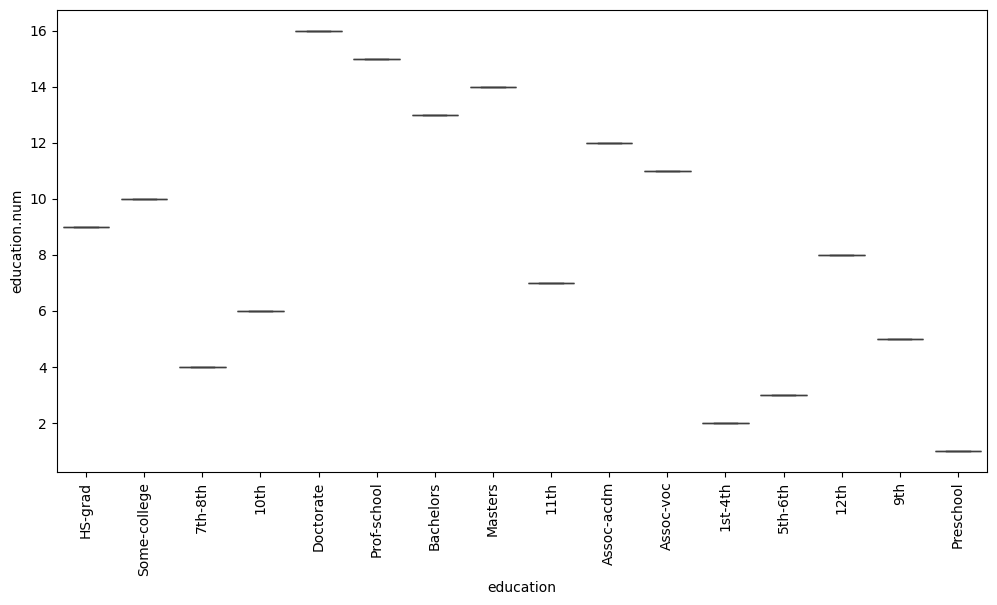

In [17]:
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.boxplot(x="education", y="education.num", data=adult)
plt.show()

Note that the diagram above is a boxplot, but we see no box in it! This shows us that `education.num` does not vary at any level of `education`. We exclude one of them from the analysis given that they two are 100% correlated.

In [18]:
adult = adult.drop(columns=['education'])

### Determine if any data needs to be transformed

First, the target:

In [19]:
adult['income_num'] = np.nan
adult.loc[adult['income'] == '<=50K', 'income_num'] = 0
adult.loc[adult['income'] == '>50K', 'income_num'] = 1

Next we look at categorical variables from the distributions above. `native.country` has 42 unique values and `occupation` has 15 levels. We consider both variables to have high cardinality, which makes target encoding a more suitable approach than one-hot encoding. We will apply target encoding later when we prepare the train and test datasets.

### Detect outliers and missing data

The histograms of the continuous variables show that some variables such as `hours.per.week` are more concentrated than others. We also notice that the highest values for `capital.gain` and `hours.per.week` are 99999 and 99 respectively, making me feel that they are capped. We will leave these values as-is without treating them as outliers. 

In [20]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  int64  
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education.num   32561 non-null  int64  
 4   marital.status  32561 non-null  object 
 5   occupation      32561 non-null  object 
 6   relationship    32561 non-null  object 
 7   race            32561 non-null  object 
 8   sex             32561 non-null  object 
 9   capital.gain    32561 non-null  int64  
 10  capital.loss    32561 non-null  int64  
 11  hours.per.week  32561 non-null  int64  
 12  native.country  32561 non-null  object 
 13  income          32561 non-null  object 
 14  income_num      32561 non-null  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 3.7+ MB


The table above shows that there are no null values present in the raw data. However, we notice that some categorical values have a value "?", meaning "unknown". We will keep this category and encode it accordingly.

### Are specific factors more important than others?

Intuitively, a person's net capital gain directly becomes part of their income, making `capital.gain` and `capital.loss` more important than others.

In [21]:
adult['net_capital_change'] = adult['capital.gain'] - adult['capital.loss']
adult['net_capital_change'].describe(percentiles=(.01, .05, .1, .25, .5, .75, .9, .95, .99))

count    32561.000000
mean       990.345014
std       7408.986951
min      -4356.000000
1%       -1980.000000
5%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%       5013.000000
99%      15024.000000
max      99999.000000
Name: net_capital_change, dtype: float64

The distribution above shows that the majority of this variable have values of 0. My usual strategy with such a distribution would be to put this variable into 3 buckets: <0, =0, >0. However, here that strategy may not be wise, as we would not want to lose the granularity. Later we will apply standard scaling to this variable. 

## Train models

### Prepare training data

#### Split into train and test sets

In [22]:
train, test = train_test_split(adult, test_size=0.33, random_state=0)

#### Scale the continuous variables

In [23]:
scaler = StandardScaler()

columns_to_scale = ['net_capital_change', 'age', 'education.num', 'hours.per.week']

scaled_train = pd.DataFrame(scaler.fit_transform(train[columns_to_scale]), \
                            index=train.index, \
                            columns=scaler.get_feature_names_out(columns_to_scale))
train[columns_to_scale] = scaled_train

scaled_test = pd.DataFrame(scaler.transform(test[columns_to_scale]), \
                            index=test.index, \
                            columns=scaler.get_feature_names_out(columns_to_scale))
test[columns_to_scale] = scaled_test

del scaled_train, scaled_test

#### Apply target encoding to categorical variables with high cardinality

In [24]:
target_encoder = TargetEncoder(smooth="auto", target_type="binary")

columns_to_target_encode = ['native.country', 'occupation']

target_encoded_train = pd.DataFrame(target_encoder.fit_transform(train[columns_to_target_encode], train['income_num']), \
                            index=train.index, \
                            columns=target_encoder.get_feature_names_out(columns_to_target_encode))
train[columns_to_target_encode] = target_encoded_train

target_encoded_test = pd.DataFrame(target_encoder.transform(test[columns_to_target_encode]), \
                            index=test.index, \
                            columns=target_encoder.get_feature_names_out(columns_to_target_encode))
test[columns_to_target_encode] = target_encoded_test

del target_encoded_train, target_encoded_test

#### Apply one-hot encoding to the other categorical variables

In [25]:
categorical_columns_to_encode = ['workclass', 'marital.status', 'relationship', 'race', 'sex']

oh_enc = OneHotEncoder(sparse=False, drop='first', handle_unknown='infrequent_if_exist')

enc_train = pd.DataFrame(oh_enc.fit_transform(train[categorical_columns_to_encode]), \
                         index=train.index, \
                         columns=oh_enc.get_feature_names_out(categorical_columns_to_encode))
train = train.join(enc_train)

enc_test = pd.DataFrame(oh_enc.transform(test[categorical_columns_to_encode]), \
                        index=test.index, \
                        columns=oh_enc.get_feature_names_out(categorical_columns_to_encode))
test = test.join(enc_test)

del enc_train, enc_test

In [26]:
X_train = train.drop(columns=['income', 'income_num'] + categorical_columns_to_encode \
                         + ['fnlwgt', 'capital.gain', 'capital.loss'])
y_train = train['income_num']

X_test = test.drop(columns=['income', 'income_num'] + categorical_columns_to_encode \
                         + ['fnlwgt', 'capital.gain', 'capital.loss'])
y_test = test['income_num']

### Prepare other helper functions

In [27]:
def show_performance(model, input_data, target, metric, \
                     show_result_score=False, show_result_plot=False, mapping=None):
    """This function shows the given performance metric of a trained model, as well as the confusion matrix.
    """
    pred = model.predict(input_data)
    
    if (isinstance(model, KMeans)) and (mapping is not None):
        pred = np.vectorize(mapping.get)(pred)
        
    score = metric(target, pred)
    
    if show_result_score==True:
        print(f'{score:.4f}')
        
    if show_result_plot==True:
        disp = ConfusionMatrixDisplay.from_predictions(target, pred, xticks_rotation='vertical')
        plt.show()

    return score

### Unsupervised learning: K-Means clustering

K-means clustering aims at partitioning a dataset into K distinct clusters. The goal of the algorithm is to group similar data points into the same cluster, while minimizing the variance within each cluster. We hope this algorithm would put individuals with similar demographic characteristics together. We will then evaluate whether this grouping agrees well with the income target.

With out data size, we do not expect K-Means clustering to be computationally expensive. However, it is worth noting that the runtime of K-Means increases quickly as the data size grows. 

#### Define and train the model

In [28]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train)

#### Evaluate performance

In [29]:
def label_permute_compare(y_true, y_pred, metric, n):
    """This function maps the groupings K-Means generates to the target data.
    """

    best_permutation = None
    best_score = 0.0
    best_predicted_labels = None

    unique_labels_true = sorted(set(y_true))

    unique_labels_predicted = sorted(set(y_pred))

    assert len(unique_labels_true) == n, \
        "the number of labels in actual data does not agree with what's specified in the parameter n"

    assert len(unique_labels_predicted) == n, \
        "the number of labels in predicted data does not agree with what's specified in the parameter n"

    # generate all possible permutations of the predicted labels
    predicted_permutations = itertools.permutations(unique_labels_predicted)
    
    all_mappings = []

    for each_permutation in predicted_permutations:
        # each mapping dictionary follows this format: {predicted label: true label}
        mapping = {key: value for key, value in zip(each_permutation, unique_labels_true)}
        all_mappings.append(mapping)

    for each_mapping in all_mappings:
        # apply the mapping to the predicted labels
        # result is a numpy array, each element is a label-encoded predicted topic
        mapped_predicted_labels = np.vectorize(each_mapping.get)(y_pred)
        score = metric(y_true, mapped_predicted_labels)

        if score > best_score:
            best_score = score
            best_mapping = each_mapping

    best_predicted_labels = np.vectorize(best_mapping.get)(y_pred)
    
    return best_mapping, best_score

In [30]:
train_pred = kmeans.predict(X_train)
best_mapping, _ = label_permute_compare(y_true=y_train, y_pred=train_pred, metric=accuracy_score, n=2)

Accuracy by K-Means clustering in train data:
0.6351


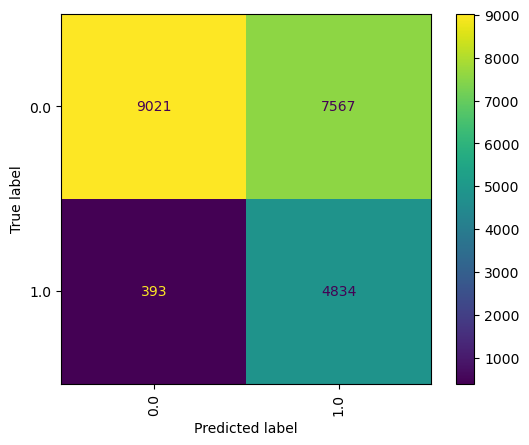

In [31]:
print('Accuracy by K-Means clustering in train data:')
kmeans_train_accuracy = show_performance(kmeans, X_train, y_train, accuracy_score, \
                                         show_result_score=True, show_result_plot=True, mapping=best_mapping)

Accuracy by K-Means clustering in test data:
0.6394


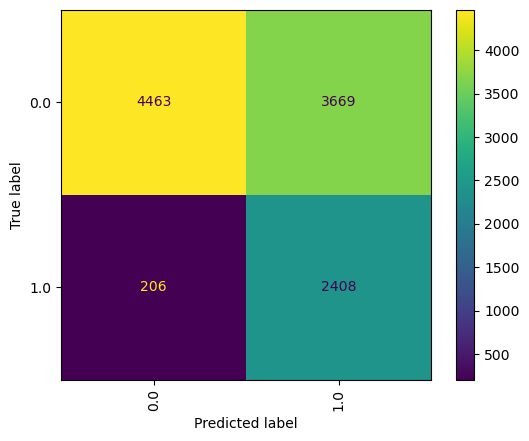

In [32]:
print('Accuracy by K-Means clustering in test data:')
kmeans_test_accuracy = show_performance(kmeans, X_test, y_test, accuracy_score, \
                                        show_result_score=True, show_result_plot=True, mapping=best_mapping)

### Supervised learning: random forest classification

Random Forest is an ensemble learning method. It operates by constructing a multitude of decision trees during training and outputs the mode of the individual trees for the input data. It is my go-to algorithm due to its speed and ease of use. Among methods that are based on decision trees, Random Forest is less prone to overfitting and yields good results without a lot of tuning. 

#### Define and train the model

In [33]:
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Evaluate performance

Accuracy by Random Forest classification in train data:
0.9929


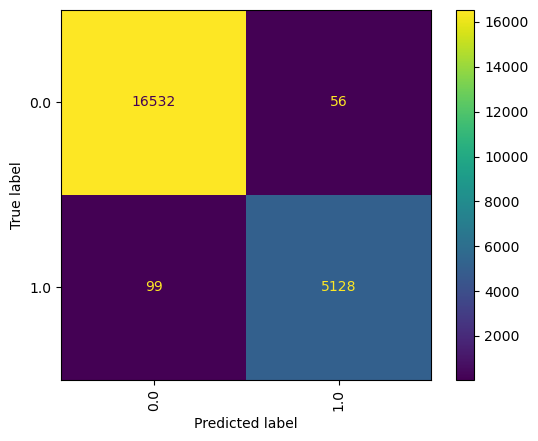

In [34]:
print('Accuracy by Random Forest classification in train data:')
rf_train_accuracy = show_performance(clf_rf, X_train, y_train, accuracy_score, \
                                     show_result_score=True, show_result_plot=True)

Accuracy by Random Forest classification in test data:
0.8550


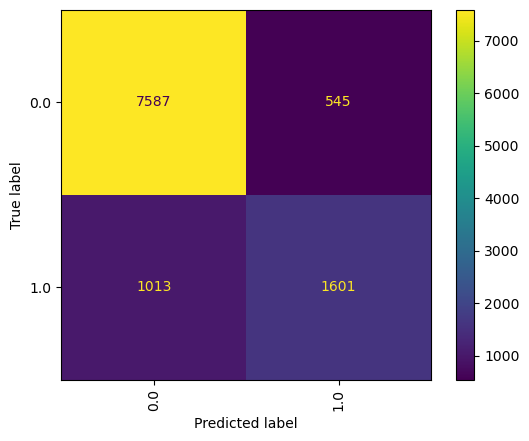

In [35]:
print('Accuracy by Random Forest classification in test data:')
rf_test_accuracy = show_performance(clf_rf, X_test, y_test, accuracy_score, \
                                    show_result_score=True, show_result_plot=True)

The large difference between train accuracy and test accuracy tells us this model is overfitting. Optimizing the model hyperparameters via cross-validation would help with this issue. 

#### Optimize the hyperparameters

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 5)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 80, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 275, 350, 425, 500], 'max_depth': [20, 40, 60, 80, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [39]:
rf = RandomForestClassifier(random_state=0)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, \
                               cv = 3, random_state=0, n_jobs = -1, scoring='accuracy')
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 275, 350, 425,
                                                         500]},
                   random_state=0, scoring='accuracy')

In [40]:
print(f"Best hyperparameters from cross-validation: {rf_random.best_params_}")
print(f"Best accuracy from cross-validation from train data: {rf_random.best_score_:.4f}")

Best hyperparameters from cross-validation: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}
Best accuracy from cross-validation from train data: 0.8652


Accuracy in test data:
0.8594


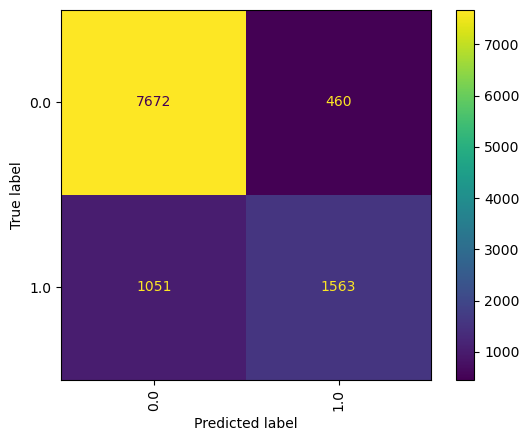

In [41]:
best_random = rf_random.best_estimator_
print("Accuracy in test data:")
rf_test_accuracy = show_performance(best_random, X_test, y_test, accuracy_score, \
                                    show_result_score=True, show_result_plot=True)

#### Additional evaluation

In the papers that use this dataset for benchmarking, they usually use accuracy score as the performance metric, just like we have been doing. But we can also use other performance metrics. 

In [42]:
print('Recall by K-Means clustering in train data:')
kmeans_train_recall = show_performance(kmeans, X_train, y_train, recall_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Recall by K-Means clustering in train data:
0.9248


In [43]:
print('Recall by K-Means clustering in test data:')
kmeans_test_recall = show_performance(kmeans, X_test, y_test, recall_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Recall by K-Means clustering in test data:
0.9212


In [44]:
print('Recall by best random forest model in test data:')
rf_test_recall = show_performance(best_random, X_test, y_test, recall_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Recall by best random forest model in test data:
0.5979


In [45]:
print('Precision by K-Means clustering in train data:')
kmeans_train_precision = show_performance(kmeans, X_train, y_train, precision_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Precision by K-Means clustering in train data:
0.3898


In [46]:
print('Precision by K-Means clustering in test data:')
kmeans_test_precision = show_performance(kmeans, X_test, y_test, precision_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Precision by K-Means clustering in test data:
0.3962


In [47]:
print('Precision by best random forest model in test data:')
rf_test_precision = show_performance(best_random, X_test, y_test, precision_score, \
                                    show_result_score=True, show_result_plot=False, mapping=best_mapping)

Precision by best random forest model in test data:
0.7726


Judging from the recall and precision scores, K-Means clustering biases towards predicting the positive outcome. I feel the Random Forest model achieves a better balance here. 

## Conclusion

The best Random Forest classification we have found yields a train accuracy score of 0.8668 and a test accuracy score of 0.8629. The K-means clustering model yields a train accuracy score of 0.6351 and a test accuracy score of 0.6394.

When comparing these methods using other evaluation metrics, Random Forest outperforms K-Means clustering as well. 

## Discussion

### Strengths
Random Forest classification demonstrates a stronger performance compared to K-Means clustering for our project. This result agrees with my expectation, as a supervised learning model will explicitly understand the relationship between the factors and the target. Unsupervised learning methods such as K-Means clustering reveal natural groupings in our data, which make them more helpful when our goal is not as explicit as this project.

### Limitations and improvement
Both modeling methods have their limitations. Random Forest is prone to overfitting, which we indeed observe from the initial model. Cross-validation significantly mitigates overfitting as well as improving predictive performance. K-Means is known to be sensitive to the initial choice of cluster centroids. In this project we did not run the algorithm multiple times with different initializations, but it is often advisable to do so as a way to improve the model.